In [1]:
from pathlib import Path

import sh
import pandas as pd
from tqdm.auto import tqdm

from utilsPlots import *


In [2]:
datadir = Path('../../datadir')

figdir = Path('./figs')
figdir.mkdir(exist_ok=True, parents=True)


In [3]:
df_info = pd.read_csv(datadir / 'participant_info.csv')
df_feat = pd.read_csv(datadir / 'video_features.csv')
df_all = df_info.merge(df_feat, on=['ID', 'day'])


In [4]:
df = df_all.copy()
df = df[df.day.isin([118, 119])]
df = df[df.duplicated(subset=['ID'], keep=False)]
df = df.sort_values('day')
N = df.ID.nunique()
print(f'{N} test-retest participants')


13 test-retest participants


In [5]:
df.groupby('ID').brooke_score.agg(['first', 'last'])


,first,last
ID,,
P019,6.0,6.0
P087,6.0,6.0
P088,6.0,6.0
P089,6.0,6.0
P092,5.0,6.0
P093,6.0,6.0
P094,5.0,5.0
P096,6.0,6.0
P097,5.0,5.0


In [6]:
def run_icc(X):
    # run R script to compute intraclass correlation
    cheese = '\n'.join([','.join([str(x) for x in row]) for row in X.tolist()])
    res = sh.Rscript("icc.R", _in=sh.echo(cheese))
    res = [x.split(',') for x in res.split('\n') if x]
    res = {x[0]:float(x[1]) for x in res}
    return res


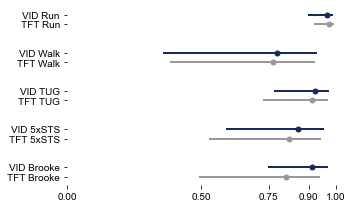

In [7]:
pairs = [
    ('10mwrt_speed', 'tft_10mwrt', 'Run'),
    ('10mwt_speed', 'tft_10mwt', 'Walk'),
    ('tug_cone_time', 'tft_tug', 'TUG'),
    ('5xsts_time_5', 'tft_5xsts', '5xSTS'),
    ('brooke_max_min_sa', 'brooke_score', 'Brooke'),
]

plt.figure(figsize=(5,3))

yticks = []
ytick_labels = []
for i, (vid_feat, tft_feat, name) in enumerate(pairs):
    df_temp = df[['ID', vid_feat]].dropna().copy()
    df_trt = df_temp.groupby('ID')[vid_feat].agg(['first', 'last'])
    X = df_trt[['first', 'last']].values
    res = run_icc(X)

    y = -i+0.125
    plt.errorbar(x=res['icc'], y=y,
             xerr=[[res['icc']-res['lbound']],
                   [res['ubound']-res['icc']]],
             fmt='o', color=cp[0],
             ms=5,
             lw=2, elinewidth=2,
             solid_capstyle='projecting', capsize=0, capthick=2)
    yticks.append(y)
    ytick_labels.append(f'VID {name}')

    df_temp = df[['ID', tft_feat]].dropna().copy()
    df_trt = df_temp.groupby('ID')[tft_feat].agg(['first', 'last'])
    X = df_trt[['first', 'last']].values
    res = run_icc(X)

    y = -i-0.125
    plt.errorbar(x=res['icc'], y=y,
             xerr=[[res['icc']-res['lbound']],
                   [res['ubound']-res['icc']]],
             fmt='o', color='#999999',
             ms=5,
             lw=2, elinewidth=2,
             solid_capstyle='projecting', capsize=0, capthick=2)
    yticks.append(y)
    ytick_labels.append(f'TFT {name}')

plt.yticks(yticks, ytick_labels)
sns.despine(left=True, bottom=True)
plt.xlim(0, 1)
plt.xticks([0, 0.5, 0.75, 0.9, 1])
plt.tight_layout()
plt.savefig(figdir / 'fig3_icc.pdf')
plt.show()


In [8]:
df_feat_key = pd.read_csv(datadir / 'feature_key.csv')
oc_feats = df_feat_key.feature_code.values.tolist()
tft_feats = ['tft_10mwrt', 'tft_10mwt', 'tft_5xsts', 'tft_tug', 'brooke_score']

feat_name_map = dict(zip(df_feat_key.feature_code, df_feat_key.name))
feat_act_map = dict(zip(df_feat_key.feature_code, df_feat_key.activity_code))

feat_color_map = {
    'Run': '#117733',
    'Walk': '#44AA99',
    'TUG': '#332288',
    '5xSTS': '#88CCEE',
    'Brooke': '#D0AB41',
    'ArmRoM': '#D0AB41',
    'Curls': '#D0AB41',
    'ToeStand': '#CC6677',
    'Jump': '#882255',
}


In [9]:
feats = tft_feats + oc_feats

data_iccs = []
for feat in tqdm(feats, leave=False):
    df_temp = df[['ID', feat]].dropna().copy()
    df_trt = df_temp.groupby('ID')[feat].agg(['first', 'last'])
    X = df_trt[['first', 'last']].values
    res = run_icc(X)
    res['feat'] = feat
    data_iccs.append(res)
df_icc = pd.DataFrame(data_iccs)
df_icc.iloc[:len(tft_feats)] = df_icc.iloc[:len(tft_feats)].sort_values(by='icc', ascending=False)
df_icc.iloc[len(tft_feats):] = df_icc.iloc[len(tft_feats):].sort_values(by='icc', ascending=False)

df_icc.to_csv('icc_results.csv', index=False)


  0%|          | 0/39 [00:00<?, ?it/s]

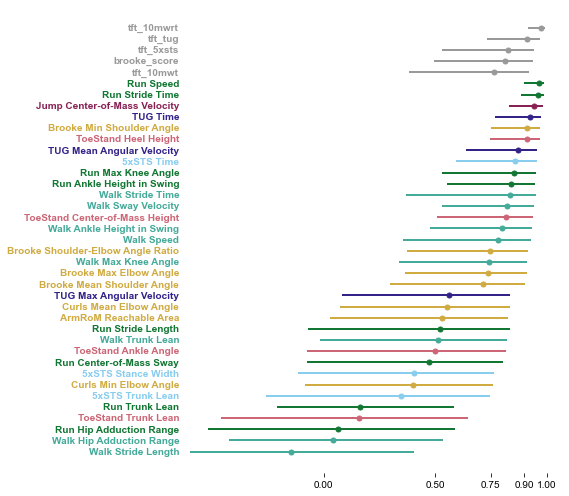

In [10]:
plt.figure(figsize=(8,7))

yticks = []
ytick_labels = []
for i, row in df_icc.iterrows():
    y = -i
    color = feat_color_map.get(feat_act_map.get(row.feat, None), '#999999')
    plt.errorbar(x=row['icc'], y=y,
                 xerr=[[row['icc']-row['lbound']],
                       [row['ubound']-row['icc']]],
                 fmt='o', color=color,
                 ms=5,
                 lw=2, elinewidth=2,
                 solid_capstyle='projecting', capsize=0, capthick=2)

    plt.text(-0.65, y, feat_name_map.get(row.feat, row.feat),
             va='center', ha='right',
             c=color, weight='bold')    

plt.xticks([0, 0.5, 0.75, 0.9, 1])
plt.yticks([], [])
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig(figdir/'fig3_icc_supplement.pdf')
plt.show()
